This was your image:



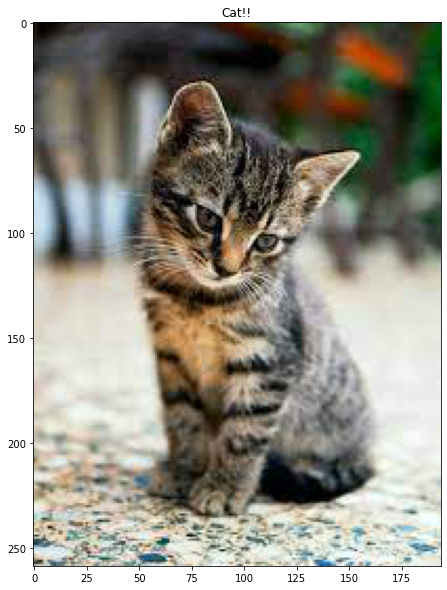


This is what it looks like now!



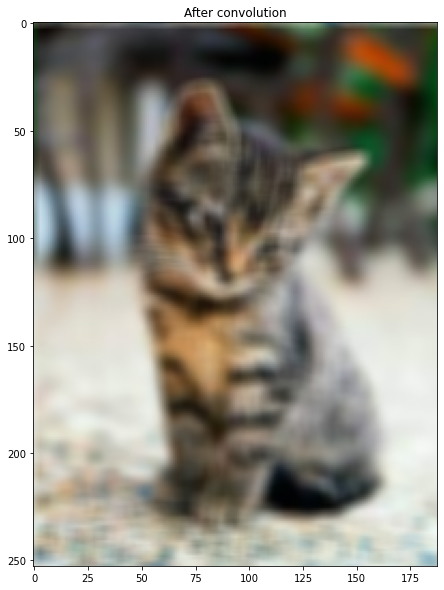

In [1]:
#import relevant modules
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt 

#NOW CREATE FUNCTIONS
#Function one - getting an image from a jpeg/png and turning it into an RGB vector
def turn_image_into_vector(file):
     
    image = Image.open(file) #use the Image.open() to open the file, but not do anything with it.

    rgb_array_of_image = np.array(image) #turn the image into a vector
    rgb_array_of_image = rgb_array_of_image.astype(np.int32)
    
    #print(f"What we have here is {rgb_array_of_image.shape[0]} x {rgb_array_of_image.shape[1]} image, with {rgb_array_of_image.shape[2]} colours in the palette"  ) #shows you what you have got getting rid of this for now
    return(rgb_array_of_image)

#function two - gets a vector and displays an image
def display_image(vector, title, size=(14,10)):
    fig = plt.figure(figsize=size)
    plt.imshow(vector)
    plt.title(title)
    plt.show()


#OK - NOW IT'S TIME TO CREATE THE CONVOLUTION MATRIX as a class

#define a class called convolution
class Blur_convolution():

#that class can have one of three names for now (e.g. blur, contract or edge detection) and a side length
    def __init__(self, length=5, type='blur', smooth='Gaussian', variance=1):
            self.length = length
            if type == 'blur':
                
                self.smoother = smooth
                if smooth == 'Gaussian':
                    self.variance = variance
                    self.convol_array = self._create_gauss_matrix()
                    
                else:
                    #this is just a really simple flat matrix
                    self.convol_array = np.zeros((length,length)) + 1/(length**2) 
            elif type == 'contrast':
                self.convol_array = np.zeros((self.length,self.length)) -0.9
                self.convol_array[int((self.length-1)/2)][int((self.length-1)/2)] = 5.5
                print(self.convol_array)

    def _create_gauss_matrix(self):
            #Gaussian formula: (1/2.pi) * exp((-1/2)*(x-µ)T * (x-µ) ) 

                var = self.variance #this could change for future
                mean_x_y = (self.length-1)/2 #this is for later calc.

                matrix = np.zeros((self.length,self.length))


                #iterate over it enumeration-style
                for x, mat_row in enumerate(matrix):
                    for y, mat_col in enumerate(matrix[x,:]):
                        x_diff = x - mean_x_y #create the (x-µ) component
                        y_diff = y - mean_x_y
                        value_for_exp = -0.5*(x_diff**2 + y_diff**2)/(var) #this calculates the section of the mv gaussian after the exponent
                        pre_norm = np.exp(value_for_exp) #perfomr the exponent (RHS of equation)
                        post_norm = (1/(2*np.pi*np.sqrt(var*2)))*pre_norm #add back in the normalising constant
                        matrix[x][y] = post_norm #set the relevant cell in the matrix to that value

                #sadly, my normalising constant doesn't seem perfect, so doing a final normalisation at the end.
                matrix = matrix / np.sum(matrix)
                return matrix

            

#that convolution then has a method where it takes image(param1), and potentially something like ('padding=False') and returns outputted image 
    def transform_image(self, image, padding = False):
        #putting in some print_test_variables for later
        
        new_image = np.zeros_like(image)
        if padding == False:
            trim_len = int((self.length-1)/2)   #for repeated use later
            for palette in range(image.shape[2]): #so we're iterating overt the colour palettes, performing the same operation for each of them.
                for row_idx, row in enumerate(image[trim_len:image.shape[0]-trim_len,:,palette]):
                    for col_idx, column in enumerate(image[row_idx,trim_len:image.shape[1]-trim_len,palette]):
                            
                            #ok now we've got down to a specific point in the image we want to change
                            value_of_cell_to_be_calculated = 0  

                            #now let's get the rows and columns for which we need to iterate over when doing our calculation (takes the ones either side of that one)
                            list_of_rows_to_be_iterated_over = np.linspace(row_idx-trim_len,row_idx+trim_len,self.length) 
                            list_of_cols_to_be_iterated_over = np.linspace(col_idx-trim_len,col_idx+trim_len,self.length)

                           

                            #so we're going to iterate over that list, and also create an enumeration of it to be used for iterating over the convolution array and mult. together
                            for row_idx_for_convol_matrix, row_in_calc in enumerate(list_of_rows_to_be_iterated_over):                                
                                for col_idx_for_convol_matrix, col_in_calc in enumerate(list_of_cols_to_be_iterated_over):
                                    value_of_cell_to_be_calculated += image[int(row_in_calc),int(col_in_calc),palette] * self.convol_array[row_idx_for_convol_matrix,col_idx_for_convol_matrix]
                                    
                            #Then, set that cell of the new_image to that value.
                            new_image[row_idx,col_idx,palette] = max(0,min(value_of_cell_to_be_calculated,255))
                           
            return new_image[:-(self.length-1),:-(self.length-1),:] #cuts off the now black cells round the edge

#OK, now what's the order of running things:
def end_to_end_image_blur_function(file, type = 'blur', length = 'auto', image_name = 'Original', smoothing = 'Gaussian', variance = 1,  padding = False):
    
    #first thing is turn image into vector
    vector_of_image = turn_image_into_vector(file)

    #print the original iamge
    print(f"This was your image:\n")
    display_image(vector_of_image,image_name,)

    #next thing is create a length for the convoluter if length is 'auto'
    if length == 'auto':
        #we want to make length odd. and it should be roughly between a third root and second root the length of the image
        length = round(vector_of_image.shape[0] **0.33) * 2 + 1 #timesing by 2 on the end there makes it even then + 1 makes it odd
        print(f"we automatically chose for you a {length} by {length} matrix")

    #then we need to initialise a Blur_convolution object
    blurrer = Blur_convolution(length = length, type = type, smooth = smoothing, variance = variance)

    #then we need to run the transform_image function of blurrer which returns a new vector
    blurred_vector = blurrer.transform_image(vector_of_image,padding = padding) 

    #then print the new image
    print(f"\nThis is what it looks like now!\n")
    display_image(blurred_vector,'After convolution')
    
myfile = '/Users/jacoblourie/computer_vision/Cat_image.jpeg'
end_to_end_image_blur_function(myfile, smoothing = 'flat',length = 7, image_name = "Cat!!")

In [ ]:
#define a class called convolution
class Edge_Detection(Blur_convolution):
    """
    this is a sub class of blur convolution
    """

#that class can have one of three names for now (e.g. blur, contract or edge detection) and a side length
    def __init__(self, length = 3,direction = 'vertical'):
            self.length = length
        
            self.convol_array = np.array([
                                [0.25,0,-0.25],
                                [0.5,0,-0.5],
                                [0.25,0,-0.25]
                                ])
            
            #can be vertical or horizontal
            if direction == 'horizontal':
                self.convol_array = np.transpose(self.convol_array)

    
    def return_abs_values(self, new_image):
        #so this is something one would call potentially                            
        new_image = np.abs(new_image)
        return new_image

#let's create an rgb_to_grey_scale in order to see if that improves edge detection    
def rgb_to_grey_scale(image_vector,scale=1):
    
    #we want to create a new matrix with the same pixel dimensions but no third column
    grey_matrix = np.zeros((image_vector.shape[0],image_vector.shape[1]))

    #for every cell, we want to take the average of the RGB values for that pixel. first let's create arrays of each of those values.
    r_values = image_vector[:,:,0]
    g_values = image_vector[:,:,1]
    b_values = image_vector[:,:,2]  

    grey_matrix = (r_values+g_values+b_values)*scale/3
    return grey_matrix
    #then we can add them together, and divide by 3.






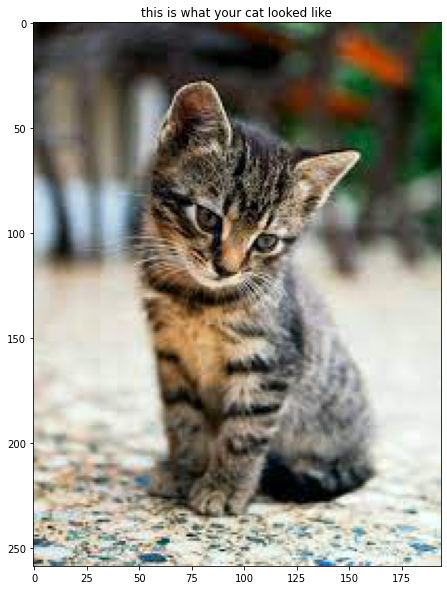

[[ 0.25  0.   -0.25]
 [ 0.5   0.   -0.5 ]
 [ 0.25  0.   -0.25]]


In [ ]:
file = '/Users/jacoblourie/computer_vision/Cat_image.jpeg'
vector_for_ED = turn_image_into_vector(file)
display_image(vector_for_ED, 'this is what your cat looked like')
ED = Edge_Detection(length=3,direction = 'vertical')
print(ED.convol_array)
changed_vector = ED.transform_image(vector_for_ED)
grey_version = rgb_to_grey_scale(changed_vector,scale = 3)

ED2 = Edge_Detection(length=3,direction='horizontal')
hor_vector = ED2.transform_image(vector_for_ED)
grey_version_hor = rgb_to_grey_scale(hor_vector,scale = 3)

fig, axList = plt.subplots(nrows = 1, ncols = 2, figsize = (10,10))
axList[0].imshow(grey_version,cmap = 'gray')
axList[1].imshow(grey_version_hor, cmap = 'gray')